In [3]:
import os
from typing import Tuple, List, Callable, Union
import numpy as np
from PIL import Image

def load_data(data_path: str, preprocess_function: Callable[[Image.Image], np.ndarray] = None) -> Tuple[np.ndarray, np.ndarray, List[Image.Image]]:
    """
    Load ORL (or Extended YaleB) dataset to numpy array.

    Args:
        data_path: Path to dataset.
        preprocess_function: The preprocess function to be applied to the image, should return a 1D numpy array.

    Returns:
        images: A numpy array of preprocessed images.
        labels: A numpy array of labels.
        raw_images: A list of original Image objects for future plotting.
    """
    
    images: List[np.ndarray] = []
    labels: List[int] = []
    raw_images: List[Image.Image] = []

    for i, person in enumerate(sorted(os.listdir(data_path))):
        person_path = os.path.join(data_path, person)
        
        if not os.path.isdir(person_path):
            continue
        
        for fname in os.listdir(person_path):
            if fname.endswith('Ambient.pgm') or not fname.endswith('.pgm'):
                continue
                
            # Load image.
            img_path = os.path.join(person_path, fname)
            img = Image.open(img_path).convert('L')  # Convert to greyscale.

            # Save raw image for future plotting
            raw_images.append(img.copy())

            # Preprocess image
            if preprocess_function:
                x_array = preprocess_function(img)
            else:
                x_array = np.array(img).flatten()

            # Collect data and label.
            images.append(x_array)
            labels.append(i)

    # Concatenate all images and labels.
    images = np.vstack(images)
    labels = np.array(labels)

    return images, labels, raw_images


In [4]:
import matplotlib.pyplot as plt

def sample_and_plot_images(raw_images: List[Image.Image], labels: np.ndarray, sample_size: int = 5):
    """
    Randomly sample images and plot them with their labels.

    Args:
        raw_images: List of original Image objects.
        labels: A numpy array of labels.
        sample_size: Number of images to sample and plot.
    """
    
    # Randomly select indices without replacement
    indices = np.random.choice(len(raw_images), sample_size, replace=False)
    
    sampled_images = [raw_images[i] for i in indices]
    sampled_labels = [labels[i] for i in indices]
    
    fig, axes = plt.subplots(1, sample_size, figsize=(15, 5))
    
    for ax, img, lbl in zip(axes, sampled_images, sampled_labels):
        ax.imshow(img, cmap='gray')
        ax.axis('off')  # Hide axes
        ax.set_title(f"Label: {lbl}")
    
    plt.tight_layout()
    plt.show()


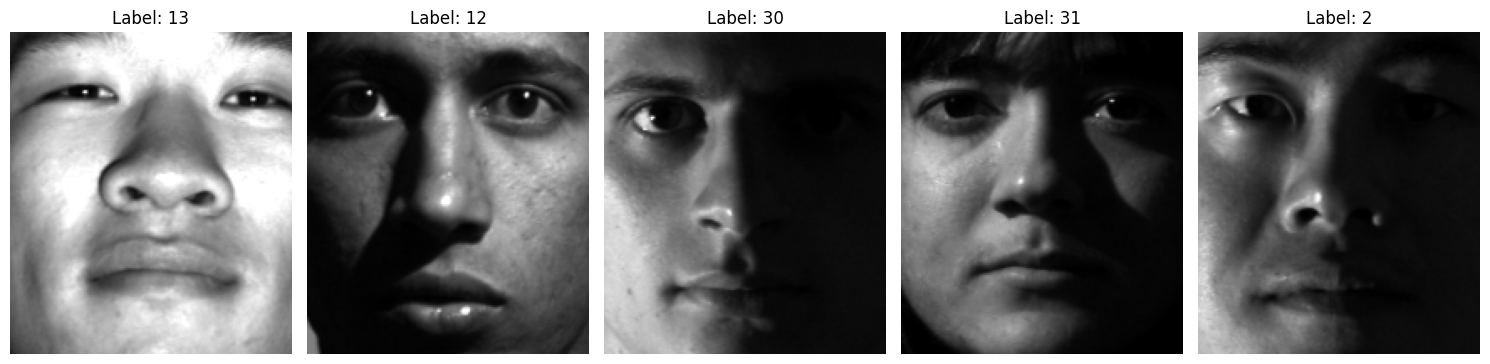

In [6]:
images, labels, raw_images = load_data(data_path='data/CroppedYaleB')
sample_and_plot_images(raw_images, labels)